## Introdução ao Keras Tuner

### Por que usar o Keras Tuner?

O **Keras Tuner** é uma ferramenta poderosa para ajustar hiperparâmetros de modelos de deep learning. Ele automatiza o processo de encontrar a configuração ideal para parâmetros como o número de filtros, taxas de aprendizado e outros aspectos do modelo, economizando tempo e esforço manual. A estratégia **Hyperband** permite explorar configurações de forma eficiente, equilibrando custo computacional e desempenho.

---

## Comparação com o Terceiro Modelo CNN

### Conclusões

1. **Desempenho em Dados Simples:**
   - O terceiro modelo CNN teve desempenho superior ao modelo ajustado com Keras Tuner.
   - Isso reforça a ideia de que, para projetos simples, modelos ajustados manualmente podem ser mais eficientes.

2. **Flexibilidade do Keras Tuner:**
   - Apesar de não ter superado o terceiro modelo CNN, o Keras Tuner permite explorar rapidamente diversas combinações de hiperparâmetros, sendo mais vantajoso em problemas mais complexos.


## Carregar dados

In [1]:
import os
from src.config import PASTA_DADOS  # Importe PASTA_DADOS de config.py em src
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras_tuner as kt
from pathlib import Path


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
mnist = keras.datasets.mnist

In [4]:
mnist

<module 'keras.api._v2.keras.datasets.mnist' from 'C:\\Users\\Usuario\\anaconda3\\envs\\projeto_mnist\\lib\\site-packages\\keras\\api\\_v2\\keras\\datasets\\mnist\\__init__.py'>

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [7]:
type(x_train[0])

numpy.ndarray

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
x_train[0][0].shape

(28,)

In [10]:
y_train.shape

(60000,)

In [11]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [12]:
import numpy as np

np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [13]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [14]:
contagem = tuple(zip(*np.unique(y_train, return_counts=True)))
contagem

((0, 5923),
 (1, 6742),
 (2, 5958),
 (3, 6131),
 (4, 5842),
 (5, 5421),
 (6, 5918),
 (7, 6265),
 (8, 5851),
 (9, 5949))

In [15]:
for par in contagem:
    print(f"{par[0]}: {par[1] / len(y_train) * 100:.2f}%")

0: 9.87%
1: 11.24%
2: 9.93%
3: 10.22%
4: 9.74%
5: 9.04%
6: 9.86%
7: 10.44%
8: 9.75%
9: 9.92%


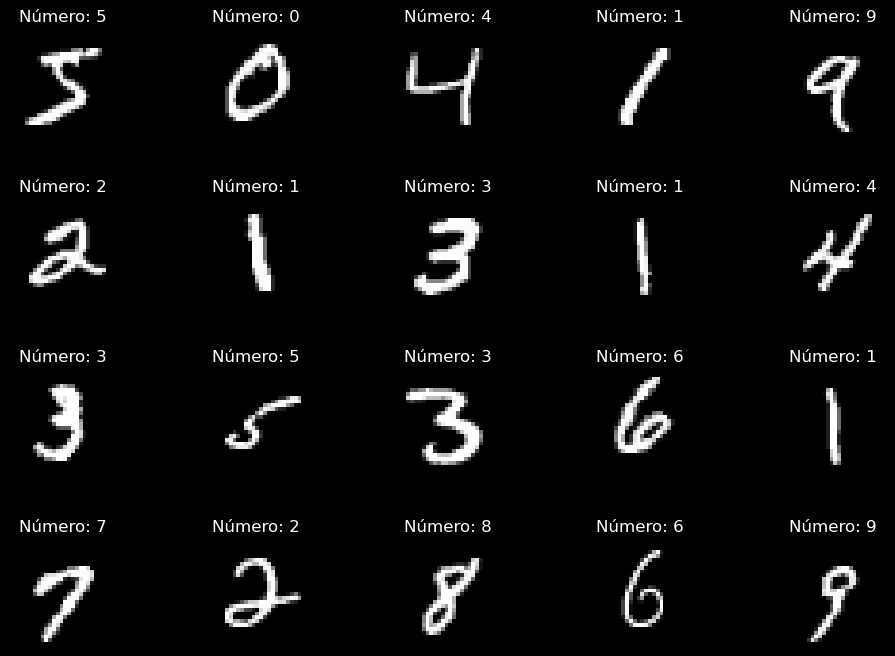

In [17]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
fig.patch.set_facecolor('black')
for i, ax in enumerate(axs.flat):
    ax.imshow(x_train[i], cmap="gray")
    ax.set_title(f"Número: {y_train[i]}", color="white")
    ax.axis("off")

fig.subplots_adjust(hspace=0.6)

plt.show()

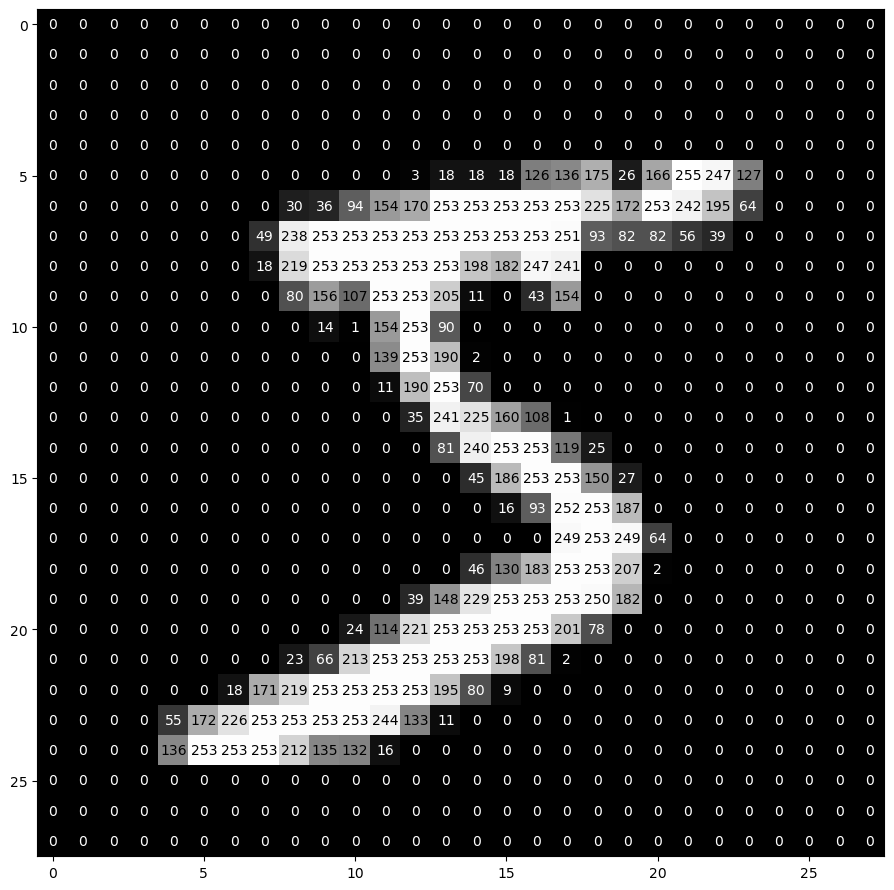

In [18]:
fig, ax = plt.subplots(figsize=(11, 11))


ax.imshow(x_train[0], cmap="gray")

for linha in range(28):
    for coluna in range(28):
        valor = x_train[0][linha][coluna]
        ax.annotate(
            str(valor),
            xy=(coluna, linha),
            color="black" if valor > 100 else "white",
            horizontalalignment="center",
            verticalalignment="center",
        )

plt.show()

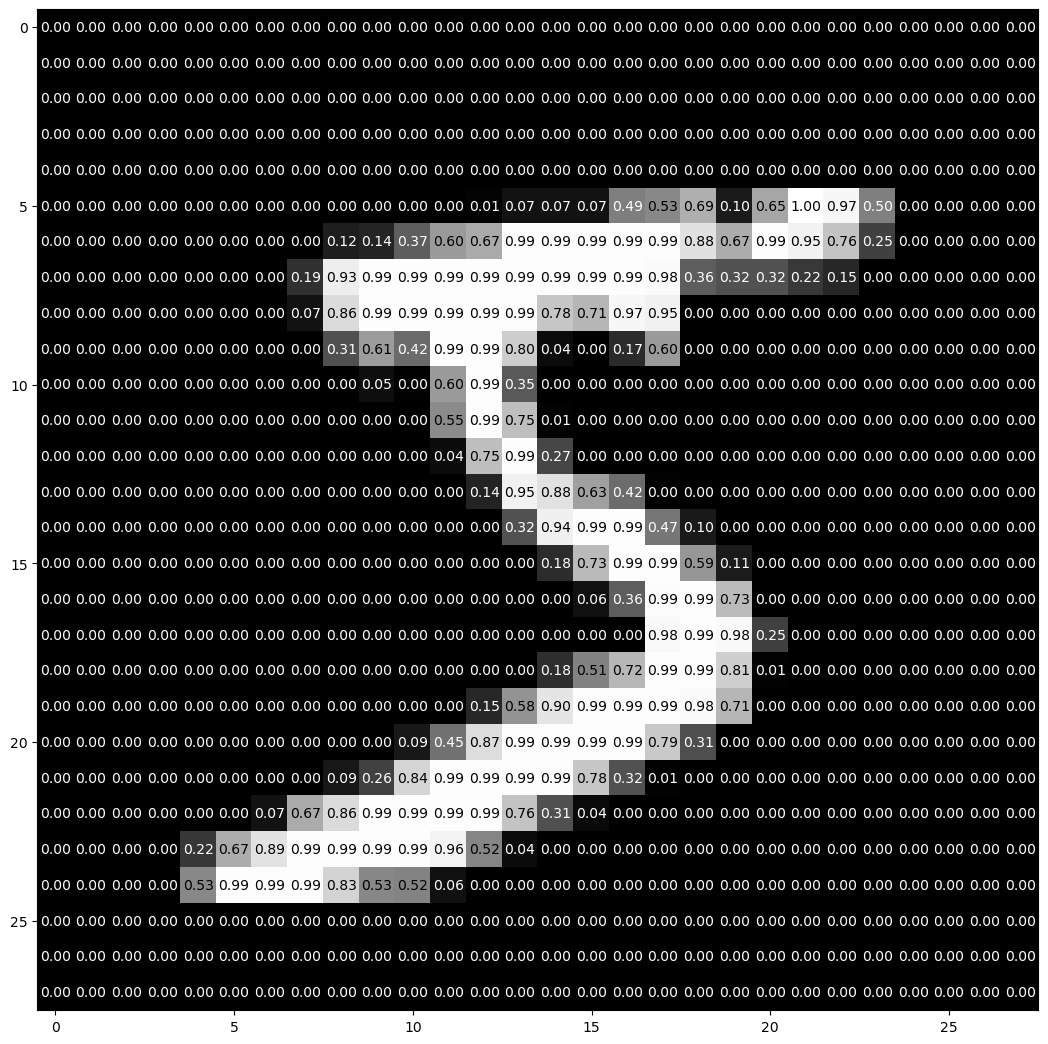

In [19]:
fig, ax = plt.subplots(figsize=(13, 13))


ax.imshow(x_train[0] / 255, cmap="gray")

for linha in range(28):
    for coluna in range(28):
        valor = x_train[0][linha][coluna] / 255
        ax.annotate(
            f"{valor:.2f}",
            xy=(coluna, linha),
            color="black" if valor > 0.5 else "white",
            horizontalalignment="center",
            verticalalignment="center",
        )

plt.show()

## Construção do Modelo com Keras Tuner

### Função de Construção do Modelo

In [20]:
def model_builder(hp):
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    model.add(keras.layers.Rescaling(scale=1./255))
    
    model.add(keras.layers.RandomRotation(0.1))
    model.add(keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1))
    model.add(keras.layers.RandomZoom(0.1))
    
    model.add(keras.layers.Conv2D(
        hp.Int("conv_1_filters", min_value=16, max_value=64, step=2, sampling="log"), 
        (3, 3), 
        activation="relu"))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(
        hp.Int("conv_2_filters", min_value=32, max_value=128, step=2, sampling="log"), 
        (3, 3), 
        activation="relu"))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1E-2, 1E-3, 1E-4]))
    loss = keras.losses.SparseCategoricalCrossentropy()
    metric = keras.metrics.SparseCategoricalAccuracy()
    
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model


## Busca de Hiperparâmetros

### Configuração do Hyperband

In [21]:
tuner = kt.Hyperband(
    model_builder,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    directory="tuner",
    project_name="mnist",
)

Reloading Tuner from tuner\mnist\tuner0.json


# Early Stopping
# Realizando a Busca

In [22]:
early_stop = keras.callbacks.EarlyStopping(
    patience=5,
    verbose=1,
    min_delta=1E-4,
)

tuner.search(
    x_train,
    y_train,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
)

## Resultados da Busca

### Melhores Hiperparâmetros

In [23]:
best_hp = tuner.get_best_hyperparameters()[0]

In [24]:
best_hp.values

{'conv_1_filters': 32,
 'conv_2_filters': 64,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

Essas configurações indicam que uma arquitetura mais simples foi suficiente para capturar as características do MNIST, reforçando que modelos mais simples podem ser mais eficientes para problemas simples.

---


## Ajuste Final do Modelo

### Treinamento com os Melhores Hiperparâmetros


In [26]:
model = tuner.hypermodel.build(best_hp)

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
)

Epoch 1/50
94/94 [==============================] - 47s 399ms/step - loss: 0.7259 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.1082 - val_sparse_categorical_accuracy: 0.9678
Epoch 2/50
94/94 [==============================] - 38s 400ms/step - loss: 0.2811 - sparse_categorical_accuracy: 0.9133 - val_loss: 0.0859 - val_sparse_categorical_accuracy: 0.9760
Epoch 3/50
94/94 [==============================] - 38s 400ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.0690 - val_sparse_categorical_accuracy: 0.9790
Epoch 4/50
94/94 [==============================] - 39s 418ms/step - loss: 0.1930 - sparse_categorical_accuracy: 0.9406 - val_loss: 0.0788 - val_sparse_categorical_accuracy: 0.9782
Epoch 5/50
94/94 [==============================] - 43s 460ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.0808 - val_sparse_categorical_accuracy: 0.9773
Epoch 6/50
94/94 [==============================] - 40s 424ms/step - loss: 0.1655 - sparse_cate

### Salvando o Modelo


In [37]:
# Caminho para a pasta models dentro de dados
models_dir = PASTA_DADOS / "models"

models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / "model_tuner_best_hps.keras"
model.save(model_path)
print(f"Modelo salvo em: {model_path}")

## Logando modelo salvo

In [40]:
loaded_model = keras.models.load_model(model_path)

In [42]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 28, 28, 1)        0         
 ranslation)                                                     
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0

## Resultados do Modelo Ajustado

### Avaliação do Modelo

**Resultados:**
- **Perda:** 0.0536
- **Acurácia:** 98.33%

---


In [44]:
loaded_model.evaluate(x_test, y_test)

313/313 [==============================] - 12s 38ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9833


[0.05358076095581055, 0.983299970626831]

In [27]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9833


[0.05358076095581055, 0.983299970626831]

### Gráficos de Evolução

#### Perda

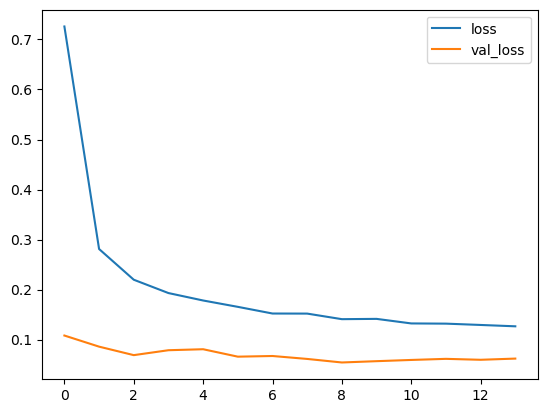

In [28]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

#### Acurácia

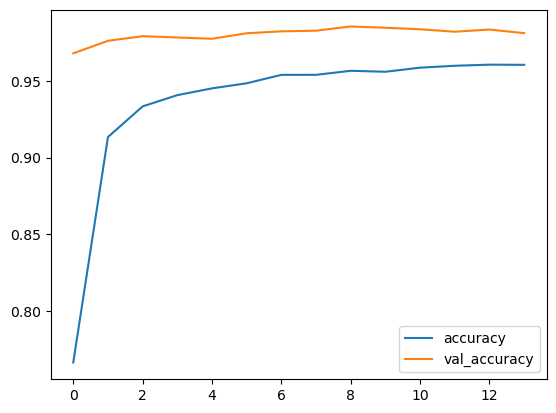

In [29]:
plt.plot(history.history["sparse_categorical_accuracy"], label="accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [30]:
x_test[0].shape

(28, 28)

In [31]:
model.predict(np.expand_dims(x_test[0], axis=0))[0]

1/1 [==============================] - 0s 160ms/step


array([1.0099473e-08, 2.7348794e-06, 1.0332584e-03, 6.8240067e-09,
       4.2629222e-10, 1.7540019e-12, 9.3696746e-17, 9.9896216e-01,
       3.5058836e-09, 1.8136349e-06], dtype=float32)

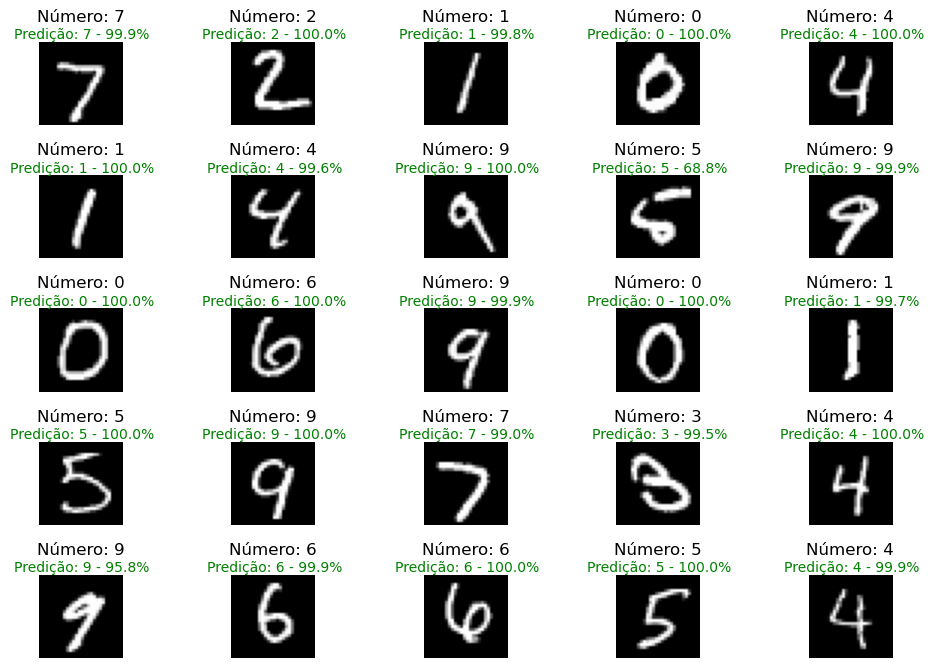

In [32]:
fig, axs = plt.subplots(5, 5, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(x_test[i], cmap="gray")
    ax.set_title(f"Número: {y_test[i]}", pad=15)
    ax.axis("off")
    pred = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0]
    ax.text(
        14,
        -3,
        f"Predição: {pred.argmax()} - {pred.max():.1%}",
        color="green" if pred.argmax() == y_test[i] else "red",
        verticalalignment="center",
        horizontalalignment="center",

        
    )

fig.subplots_adjust(hspace=0.6)

plt.show()

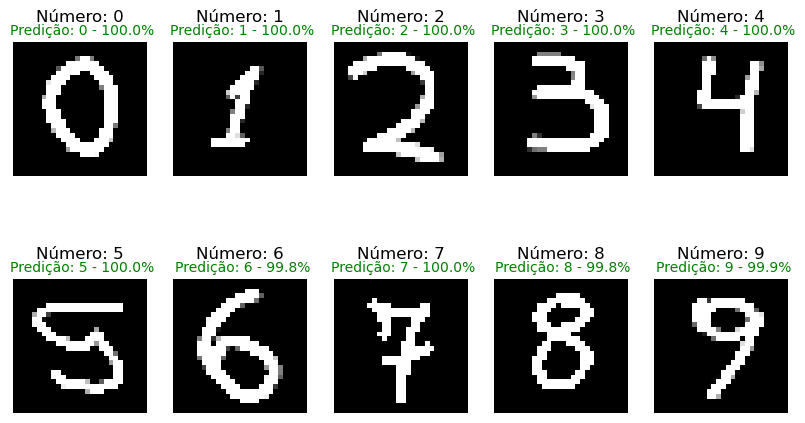

In [36]:
# Caminho para a pasta test_images dentro de PASTA_DADOS
test_images_dir = PASTA_DADOS / "test_images"


if not test_images_dir.exists():
    raise FileNotFoundError(f"A pasta {test_images_dir} não foi encontrada!")

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

all_pred = {}


for i, (img, ax) in enumerate(zip(sorted(test_images_dir.glob("*.png")), axs.flat)):
    name = img.name.split(".")[0]
    img = keras.preprocessing.image.load_img(
        img, target_size=(28, 28), color_mode="grayscale"
    )

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = 255 - img_array  
    img_array = tf.expand_dims(img_array, 0)


    pred = model.predict(img_array, verbose=0)
    all_pred[name] = pred


    ax.imshow(img_array[0], cmap="gray")
    ax.set_title(f"Número: {name}", pad=15)
    ax.axis("off")
    ax.text(
        14,
        -3,
        f"Predição: {pred.argmax()} - {pred.max():.1%}",
        color="green" if str(pred.argmax()) == name else "red",
        verticalalignment="center",
        horizontalalignment="center",
    )

fig.subplots_adjust(hspace=0.6)

plt.show()

In [34]:
all_pred["9"]

array([[2.4460416e-09, 5.0558576e-12, 8.3763553e-05, 9.8184846e-06,
        3.2509395e-06, 1.7086467e-07, 3.5774374e-18, 1.1619041e-03,
        1.6137242e-04, 9.9857962e-01]], dtype=float32)

In [35]:
all_pred["3"]

array([[3.1160282e-13, 1.5668830e-12, 1.0226522e-04, 9.9989665e-01,
        5.9545122e-14, 1.2496757e-09, 1.2195040e-22, 1.0710905e-06,
        1.0452823e-10, 1.2166217e-13]], dtype=float32)